# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Behavioral Cloning

In this project, the purpose is to train an AI agent to drive a car around a track in Udacity's simulator.

## Files in this repository
- model.py - The script used to create and train the model.
- drive.py - The script to drive the car. You can feel free to resubmit the original drive.py or make modifications and submit your modified version.
- model.json - The model architecture.
- model.h5 - The model weights.

Note: This repository does not include the simulator built by Udacity or the training data used to generate the model.    

## Running the Simulator

Running the Simulator
The Self-Driving Car Simulator you will use in this project.
The Self-Driving Car Simulator you will use in this project.
Once you’ve downloaded the simulator (see previous lecture slide "Project Resources"), extract it and run it.

![Image](https://d17h27t6h515a5.cloudfront.net/topher/2016/October/580eaf55_screen-shot-2016-10-24-at-6.02.47-pm/screen-shot-2016-10-24-at-6.02.47-pm.png)


When you first run the simulator, you’ll see a configuration screen asking what size and graphical quality you would like. We suggest running at the smallest size and the fastest graphical quality. We also suggest closing most other applications (especially graphically intensive applications) on your computer, so that your machine can devote its resource to running the simulator.

## Training Mode
![image](https://d17h27t6h515a5.cloudfront.net/topher/2016/October/580ab5c3_screen-shot-2016-10-21-at-5.40.48-pm/screen-shot-2016-10-21-at-5.40.48-pm.png)


Select Training Mode in the above screen to start driving the car.
Select Training Mode in the above screen to start driving the car.
The next screen gives you two options: Training Mode and Autonomous Mode.

First, select Training Mode.

You’ll enter the simulator and be able to drive the car with your arrow keys, just like it’s a video game. Try it!

Autonomous mode will be used in a later step once the neural network is trained.

## Collecting Training Data
In order to start collecting training data, you'll need to do the following:

Enter Training Mode in the simulator.
Start driving the car to get a feel for the controls.
When you are ready, hit the record button in the top right to start recording.
Continue driving for a few laps or till you feel like you have enough data.
Hit the record button in the top right again to stop recording.
If everything went correctly, you should see the following in the directory you selected:

IMG folder - this folder contains all the frames of your driving.
driving_log.csv - each row in this sheet correlates your image with the steering angle, throttle, brake, and speed of your car. You'll mainly be using the steering angle.

---

## Step 1: Dataset Summary & Exploration


In [16]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, Convolution2D, Lambda, Activation, MaxPooling2D, Cropping2D
from keras.layers.advanced_activations import ELU
from keras.preprocessing.image import ImageDataGenerator 
from keras.optimizers import SGD
from keras.layers import Input
import os

In [17]:
data_dirname = "data"
csv = "driving_log.csv"
driving_log = pd.read_csv(os.path.join(data_dirname, csv))

In [18]:
driving_log.head()
driving_log.keys()

Index(['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'], dtype='object')

In [19]:
n_train = len(driving_log)
print("Number of training examples =", n_train)

Number of training examples = 8036


In [20]:
central_images = driving_log["center"]
steering_angles = driving_log["steering"]
central_images.head()

0    IMG/center_2016_12_01_13_30_48_287.jpg
1    IMG/center_2016_12_01_13_30_48_404.jpg
2    IMG/center_2016_12_01_13_31_12_937.jpg
3    IMG/center_2016_12_01_13_31_13_037.jpg
4    IMG/center_2016_12_01_13_31_13_177.jpg
Name: center, dtype: object

## Visualize Data

View a sample from the dataset.

Steering angle: 0.2339935
Image dimensions: (160, 320, 3)
Number of training examples: (16072,)


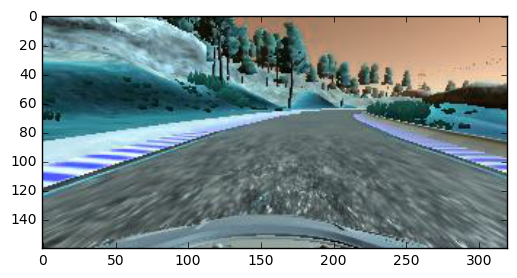

In [7]:
index = random.randint(0, n_train)
image = X_train[index].squeeze()
image_dims = image.shape
output_dims = y_train.shape

plt.imshow(image)
print("Steering angle: {}".format(y_train[index]))
print("Image dimensions: {}".format(image_dims))
print("Number of training examples: {}".format(output_dims))

## Data Augmentation 

1. Load image and steering angle data.
2. Generate an additional image by flipping the original image and inverting the steering angle data.

In [24]:
X_train =[]
y_train = []

for index, image_path in enumerate(central_images):
    f = os.path.join(data_dirname, image_path)
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    steering = steering_angles[index]
    X_train.append(img)
    y_train.append(steering)
    
    rimg = cv2.flip(img, 1)
    r_steering = steering * -1
    X_train.append(rimg)
    y_train.append(r_steering)

X_train = np.array(X_train)
y_train = np.array(y_train)

## Preprocess Data

1. Shuffle the training data.
2. Crop off the top 20 pixels of the image.
3. Resize the images from 320 by 120 to 32 by 12. 
3. Converts images from RGB to Grayscale.  
4. Normalize the features using Min-Max scaling between -0.5 and 0.5 

In [25]:
X_train, y_train = shuffle(X_train, y_train)

#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=0)

In [26]:
def resize(image):
    import tensorflow as tf
    return tf.image.resize_images(image, (16, 32))

def grayscale(image):
    import tensorflow as tf
    return tf.image.rgb_to_grayscale(image)

def normalize(image):
    '''Normalize the image to be between -0.5 and 0.5'''
    return image / 255.0 - 0.5

def base_model(image_dims):
    ch, row, col = image_dims 
    model = Sequential()
    model.add(Lambda(resize, input_shape=(ch, row, col)))
    model.add(Lambda(grayscale))
    model.add(Lambda(normalize))    
    return model 

In [ ]:
def comma_ai_model(image_dims):
    
    model = base_model(image_dims)
    
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))    
    model.add(ELU())
    
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    
    model.add(Dense(1))  
    model.compile(optimizer="adam", loss="mse")
    
    return model

def nvidia_model(image_dims):
    model = base_model(image_dims)
    
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid'))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid'))

    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dense(50))
    model.add(Dense(10))        
    model.add(Dense(1))        
    model.compile(optimizer="adam", loss="mse")
    
    return model

def simple_model(image_dims):
    model = base_model(image_dims)
    
    model.add(Convolution2D(32, 3, 3))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(43))
    model.add(Activation('relu'))
    model.add(Dense(1))        
    model.compile(optimizer="adam", loss="mse")
    
    return model

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**


The images are arranged chronologically.  The data must be shuffled so that the training and validation set will contain images from all the tracks.  The top 20 pixels have been cropped off because the sky should not have any influence on driving.  I have found that shrinking the images and converting to grayscale greatly improved the AI agent's ability to drive.  It also speeds up the training process.  The feature values have been normalized to have zero mean and equal variance.  This transformation makes it easier for the model to find a good solution.  The preprocessing is integrated into my model so it will work when the simulator is running.   

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

Normally, data is divided into a training set and a test set.  I did not set aside any for a test set because my model is being evaluated based on the successful navigation of the first track in autonomous mode.  However, I use a validation_split of 10 percent when I'm training my model.  Additional data was generated by flipping the images and inverting the steering angle.  This technique doubles the amount of training data.  


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

In [30]:
model = simple_model(image_dims)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 16, 32, 3)     0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
lambda_5 (Lambda)                (None, 16, 32, 1)     0           lambda_4[0][0]                   
____________________________________________________________________________________________________
lambda_6 (Lambda)                (None, 16, 32, 1)     0           lambda_5[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 30, 32)    320         lambda_6[0][0]                   
___________________________________________________________________________________________

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_

In [12]:
batch_size = 50
nb_epoch = 5

model.fit(X_train, y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_split=0.1)

Train on 14464 samples, validate on 1608 samples
Epoch 1/5
14464/14464 [==============================] - 21s - loss: 0.0128 - val_loss: 0.0109
Epoch 2/5
14464/14464 [==============================] - 21s - loss: 0.0106 - val_loss: 0.0107
Epoch 3/5
14464/14464 [==============================] - 21s - loss: 0.0099 - val_loss: 0.0100
Epoch 4/5
14464/14464 [==============================] - 21s - loss: 0.0094 - val_loss: 0.0096
Epoch 5/5
14464/14464 [==============================] - 22s - loss: 0.0088 - val_loss: 0.0097


**Answer:**

The Optimizer used was the Adam Optimizer.  The batch size was 50, and I used 5 epochs.

In [13]:
model.save_weights("model.h5")
print('saving weights')

# Save model config (architecture)
json_string = model.to_json()
with open("model.json", "w") as f:
    f.write(json_string)

print('saving model')

saving weights
saving model


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**


It was a process of trial and error.  I started out by transfer learning.  I used the Keras built in implementation of the Google InceptionV3 model.  The input and output layers were modified for this problem.  Additional layers were added, and the weights in the original layers were frozen during training.  The model performed so poorly that the car crashed within seconds.  

I researched what other students in the program doing were doing.  Many students reported good results using the models from Nvidia and CommaAi.  The Comma AI perform pretty well.  The Nvidia did not perform as well, and it performed poorly when I used activation layers.  The Nvidia performed much better when I removed the activation layers and simplified it.

I used the final model from the Keras Lab.  This model was able to finish driving around the track, and it was the simplest model of all the ones that I tried.    